In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
from torch.utils.data import random_split

In [8]:
# 1. SETTINGS & PATHS
data_dir = '/content/gdrive/MyDrive/Datas/crack/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
print(device)

cuda


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [11]:
# 2. Split into 80% train and 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 3. Create two separate loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training images: {len(train_dataset)}, Validation images: {len(val_dataset)}")

Training images: 1718, Validation images: 430


In [12]:
print(f"Loaded {len(dataset)} images.")
print(f"Classes found: {dataset.classes}")

Loaded 2148 images.
Classes found: ['crack', 'no_crack']


In [13]:
# 4. INITIALIZE ResNet18 & FREEZE BACKBONE
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


In [14]:
# 5. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [15]:
# 6. TRAINING & VALIDATION LOOP
def train_and_validate(epochs=5):
    for epoch in range(epochs):
        # --- TRAINING PHASE ---
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # --- VALIDATION PHASE ---
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        val_acc = 100. * val_correct / val_total
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}%")

# Start
train_and_validate(epochs=5)

Epoch 1/5 - Train Loss: 0.4786 | Val Acc: 91.16%
Epoch 2/5 - Train Loss: 0.2937 | Val Acc: 92.79%
Epoch 3/5 - Train Loss: 0.2455 | Val Acc: 93.26%
Epoch 4/5 - Train Loss: 0.2398 | Val Acc: 93.02%
Epoch 5/5 - Train Loss: 0.1963 | Val Acc: 93.72%


In [17]:
# Define the save path
model_path = '/content/gdrive/MyDrive/Datas/crack_resnet18_model.pth'

# Save the state dictionary
torch.save(model.state_dict(), model_path)

print(f"Model successfully saved to {model_path}!")

Model successfully saved to /content/gdrive/MyDrive/Datas/crack_resnet18_model.pth!


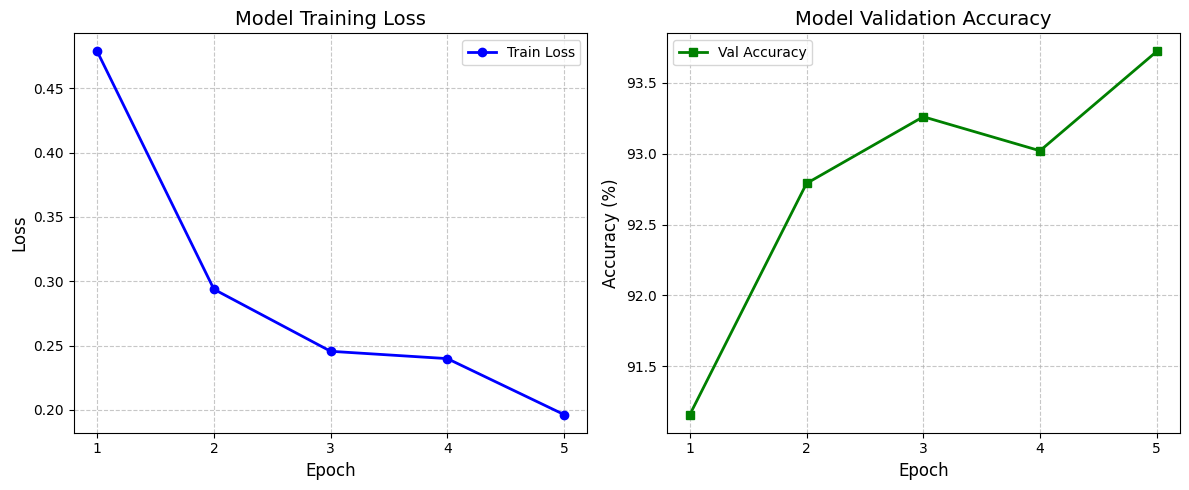

In [20]:
import matplotlib.pyplot as plt

# Values taken directly from your successful training output
epochs = [1, 2, 3, 4, 5]
train_loss = [0.4786, 0.2937, 0.2455, 0.2398, 0.1963]
val_acc = [91.16, 92.79, 93.26, 93.02, 93.72]

# Create the figure
plt.figure(figsize=(12, 5))

# Plot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'o-', color='blue', linewidth=2, label='Train Loss')
plt.title('Model Training Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Plot 2: Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc, 's-', color='green', linewidth=2, label='Val Accuracy')
plt.title('Model Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()